## Analyzing Portfolio Sensitivities to the Fama-French Factors

In [1]:
!pip install pandas_datareader

In [2]:
import warnings

In [26]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings("ignore")
obb.user.preferences.output_type = "dataframe"

Define the stock symbols including the benchmark "SPY"

In [5]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "SPY"]

Fetch historical price data for the defined symbols from 2015-01-01 to 2022-12-31 using the "yfinance" provider

In [6]:
data = obb.equity.price.historical(
    symbols,
    start_date="2015-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

Calculate the monthly percentage returns and convert the index to a monthly period

In [7]:
# Calcula os retornos percentuais mensais e converte o índice para período mensal
monthly_returns = data.asfreq("ME").pct_change(fill_method=None).to_period("M")

The result is a DataFrame with monthly returns suitable for alignment with the Fama-French monthly factor data

In [24]:
monthly_returns

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SSRM,UNH
date,,,,,,,,
2015-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,0.108280,-0.013917,-0.010736,0.036187,0.220175,0.022500,0.203090,-0.058247
2015-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,0.239130,0.012520,0.073432,0.008903,0.016199,0.020892,0.090437,-0.027516


Next, we compute the active returns and use them as the dependent variable. This will help us understand the sensitivity of
the Fama-French factors to our active returns.

In [8]:
# Remove o SPY (benchmark) do DataFrame de retornos mensais
bench = monthly_returns.pop("SPY")

# Calcula a média dos retornos mensais das ações (retorno do portfólio)
R = monthly_returns.mean(axis=1)

# Calcula os retornos ativos (diferença entre retorno do portfólio e benchmark)
# e remove valores nulos
active = (R - bench).dropna()

Fetch the Fama-French factors data

In [9]:
# Obtém os dados dos fatores Fama-French do banco de dados
factors = (
    pdr.get_data_famafrench(
        "F-F_Research_Data_Factors",  # Nome do dataset dos fatores
        start="2015-01-01",          # Data inicial
        end="2022-12-31",            # Data final
    )[0][1:]                         # Seleciona apenas os dados dos fatores (exclui Rf)
    / 100                            # Converte de percentual para decimal
)

# Extrai os fatores SMB (Small Minus Big) e HML (High Minus Low)
# alinhados com o índice dos retornos ativos
SMB = factors.loc[active.index, "SMB"]  # Fator tamanho
HML = factors.loc[active.index, "HML"]  # Fator valor

In [10]:
help(pdr.get_data_famafrench)

Help on function get_data_famafrench in module pandas_datareader.data:

get_data_famafrench(*args, **kwargs)



Create a DataFrame with the active returns and Fama-French factors

In [11]:
df = pd.DataFrame(
    {
        "R": active,
        "SMB": SMB,
        "HML": HML,
    },
    index=active.index,
).dropna()

Perform linear regression to estimate the sensitivities of active returns to the factors

In [12]:
b1, b2 = regression.linear_model.OLS(df.R, df[["SMB", "HML"]]).fit().params

In [13]:
display(f"Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}")

'Sensitivities of active returns to factors:\nSMB: 0.0876106742871349\nHML: -0.026381516925070413'

Perform rolling regression to estimate the time-varying sensitivities

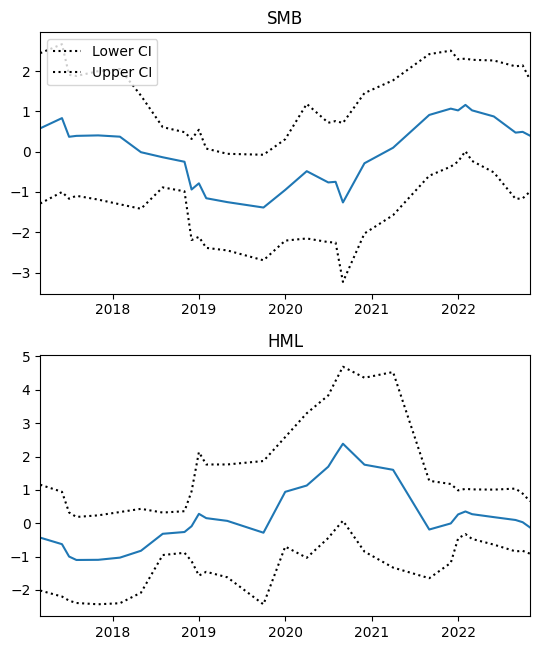

In [ ]:
# Adiciona uma constante aos fatores SMB e HML para a regressão
exog = sm.add_constant(df[["SMB", "HML"]])

# Cria um modelo de regressão móvel com janela de 12 períodos
rols = RollingOLS(active, exog, window=12)

# Ajusta o modelo de regressão móvel
rres = rols.fit()

# Plota os coeficientes recursivos para SMB e HML
fig = rres.plot_recursive_coefficient(variables=["SMB", "HML"], figsize=(5.5, 6.6))

Estimate the marginal contributions to active risk (MCAR)

In [15]:
F1 = df.SMB
F2 = df.HML
cov = np.cov(F1, F2)
ar_squared = (active.std()) ** 2
mcar1 = (b1 * (b2 * cov[0, 1] + b1 * cov[0, 0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0, 1] + b2 * cov[1, 1])) / ar_squared

In [16]:
display(f"SMB risk contribution: {mcar1}")
display(f"HML risk contribution: {mcar2}")
display(f"Unexplained risk contribution: {1 - (mcar1 + mcar2)}")

'SMB risk contribution: 0.0013691270661885554'

'HML risk contribution: 0.0003004883012588716'

'Unexplained risk contribution: 0.9983303846325525'

Calculate the rolling covariances and active risk squared

In [17]:
covariances = (df[["SMB", "HML"]].rolling(window=12).cov()).dropna()

In [18]:
active_risk_squared = (active.rolling(window=12).std() ** 2).dropna()

Calculate the rolling betas

In [19]:
betas = pd.concat([rres.params.SMB, rres.params.HML], axis=1).dropna()

Create a DataFrame to store the MCAR estimates

In [20]:
MCAR = pd.DataFrame(index=betas.index, columns=betas.columns)

Calculate the MCAR for each factor at each time point

In [21]:
for factor in betas.columns:
    for t in betas.index:
        # Compute the sum of the betas and covariances
        s = np.sum(betas.loc[t] * covariances.loc[t][factor])
        # Get the beta
        b = betas.loc[t][factor]
        # Get active risk squared
        AR = active_risk_squared.loc[t]
        # Put them all together to estimate FMCAR on that date
        MCAR[factor][t] = b * s / AR

Plot the MCAR estimates for each factor

Text(0, 0.5, 'MCAR')

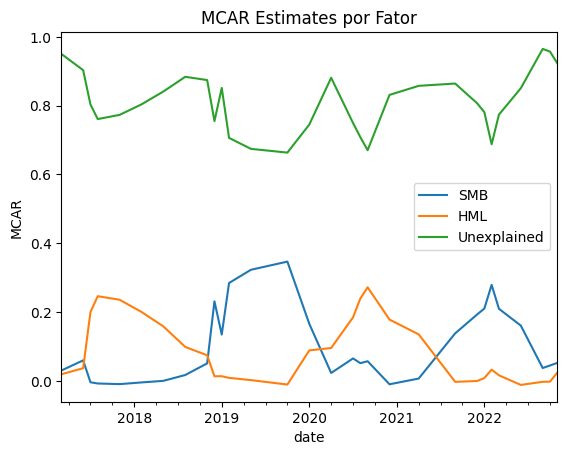

In [28]:
MCAR.SMB.plot()
MCAR.HML.plot()
(1 - (MCAR.SMB + MCAR.HML)).plot()
plt.legend(['SMB', 'HML',"Unexplained"])
plt.title('MCAR Estimates por Fator')
plt.ylabel('MCAR')


Plot the unexplained risk contribution

<Axes: xlabel='date'>

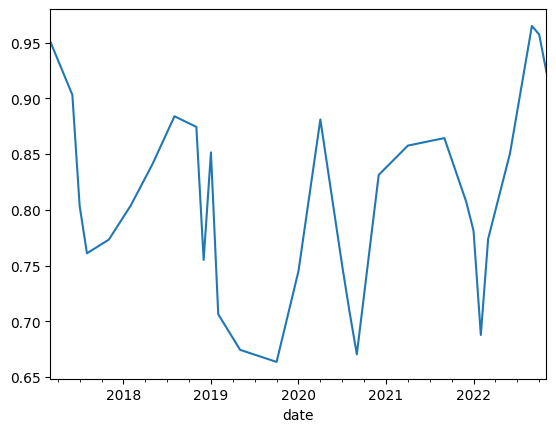

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.